In [15]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
# tf.debugging.set_log_device_placement(True)
tf.test.gpu_device_name()

'/device:GPU:0'

In [16]:
# Define function for image rotation
def rotate(image, angle):
    # Get image height, width
    (h, w) = image.shape[:2]

    # Calculate the center of the image
    center = (w / 2, h / 2)

    # Rotate the image by the specified angle
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

# Define function for image noising
def add_noise(image, sigma):
    # Generate Gaussian noise
    noise = np.random.normal(0, sigma, image.shape)

    # Add the noise to the image
    noisy_image = np.clip(image + noise, 0, 255).astype(np.uint8)

    return noisy_image

In [17]:
## LOAD DATA
# Define the path to dataset folder
dataset_folder = 'subset/1/'

# Create empty list to store images
images_origin = []

HEIGHT = 128
WIDTH = 128

# Iterate through each file in the dataset folder
for filename in os.listdir(dataset_folder):
    image_path = os.path.join(dataset_folder, filename)

    # Load the image
    img = cv2.imread(image_path)

    # Convert to gray_scale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get image dimensions
    height, width = img_gray.shape[:2]

    # Define the rotation angle in degrees
    angle = 180

    # Define the rotation center
    center = (width / 2, height / 2)

    # Perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_img = cv2.warpAffine(img_gray, M, (width, height))

    # Define the region of interest (ROI) to crop
    x1, y1, x2, y2 = 260, 669, 933, 1155
    roi = rotated_img[y1:y2, x1:x2]
            
    # Resize the image
    img_resized = cv2.resize(roi, (HEIGHT,WIDTH))

    # Append the image to the list of images
    images_origin.append(img_resized)

## DATA Augmentation

# Define rotation angle in degrees
angle = 90

# Define standard deviation of the Gaussian noise
sigma = 30

# Augment the dataset by rotation and noising
images_flipped = np.array([cv2.flip(image, 0) for image in images_origin])
images_noisy = np.array([add_noise(image, sigma) for image in images_origin])

# Concatenate the original and augmented datasets
X = np.concatenate((images_origin,images_noisy,images_flipped), axis=0)
# y = np.concatenate((images_origin,images_origin,images_flipped), axis=0)
# X_train, X_test= train_test_split(images)
# 
# X_train = np.reshape(X_train,(len(X_train),128,128))

#Normalize
X = X.astype("float32") / 255.0
# y = y.astype("float32") / 255.0



In [18]:
HEIGHT = 128
WIDTH = 128
X = np.reshape(X,(len(X),HEIGHT,WIDTH,1))
# y = np.reshape(y,(len(y),HEIGHT,WIDTH,1))

In [19]:
X.shape

(3330, 128, 128, 1)

In [20]:
# y.shape

In [21]:
# Define the autoencoder model
input_img = keras.Input(shape=X.shape[1:])

# Encoder Layers
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = keras.layers.MaxPooling2D((2, 2), padding='same')(x)

# Decoder Layers
x = keras.layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.UpSampling2D((2, 2))(x)
decoded = keras.layers.Conv2D(X.shape[3], (3, 3), activation='sigmoid', padding='same')(x)

# Define the SSIM loss function
def ssim_loss(y_true, y_pred):
    ssim_value = tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))
    return 1.0 - ssim_value

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=ssim_loss)

# Train the autoencoder
autoencoder.fit(X, X,
                epochs=20,
                batch_size=16,
                shuffle=True)


Epoch 1/20
209/209 [==============================] - 13s 49ms/step - loss: 0.5182
Epoch 2/20
209/209 [==============================] - 10s 50ms/step - loss: 0.4401
Epoch 3/20
209/209 [==============================] - 10s 48ms/step - loss: 0.4252
Epoch 4/20
209/209 [==============================] - 10s 48ms/step - loss: 0.4185
Epoch 5/20
209/209 [==============================] - 11s 53ms/step - loss: 0.4134
Epoch 6/20
209/209 [==============================] - 11s 53ms/step - loss: 0.4087
Epoch 7/20
209/209 [==============================] - 11s 52ms/step - loss: 0.4046
Epoch 8/20
209/209 [==============================] - 12s 57ms/step - loss: 0.4013
Epoch 9/20
209/209 [==============================] - 12s 56ms/step - loss: 0.3985
Epoch 10/20
209/209 [==============================] - 11s 54ms/step - loss: 0.3960
Epoch 11/20
209/209 [==============================] - 12s 56ms/step - loss: 0.3933
Epoch 12/20
209/209 [==============================] - 12s 56ms/step - loss: 0.3911
E

In [22]:
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 16)        9232      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 8)         1160

105/105 [==============================] - 3s 24ms/step


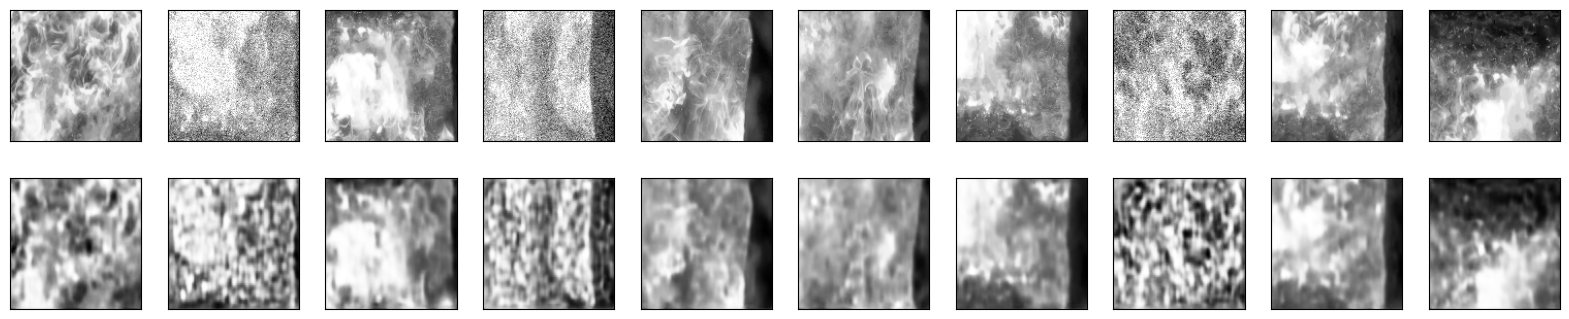

In [23]:
import random
decoded_imgs = autoencoder.predict(X)
n = 10  # Number of images to display
plt.figure(figsize=(20, 4))
for i in range(n):
    random_number = random.randint(0, len(X)-1)
    # Display original image
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X[random_number])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstructed image
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[random_number])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [24]:
# Extract the deep features
encoder = keras.Model(input_img, encoded)
encoded_imgs = encoder.predict(X)


105/105 [==============================] - 1s 7ms/step


In [25]:
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape(len(X), 2048)

(3330, 16, 16, 8)


In [26]:
# Cluster the encoded images using K-means
kmeans = KMeans(n_clusters=2, random_state=0).fit(encoded_imgs)

# Print the cluster centers
print(kmeans.cluster_centers_)

d:\Programmes\miniconda3\envs\env_master_project\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[[0.11619157 0.15250607 0.46806052 ... 0.22938918 0.25130355 0.16387597]
 [0.1363833  0.26996055 0.5604721  ... 0.300089   0.34068045 0.10151003]]


C:\Users\nrozo\AppData\Local\Temp\ipykernel_17100\285277098.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],


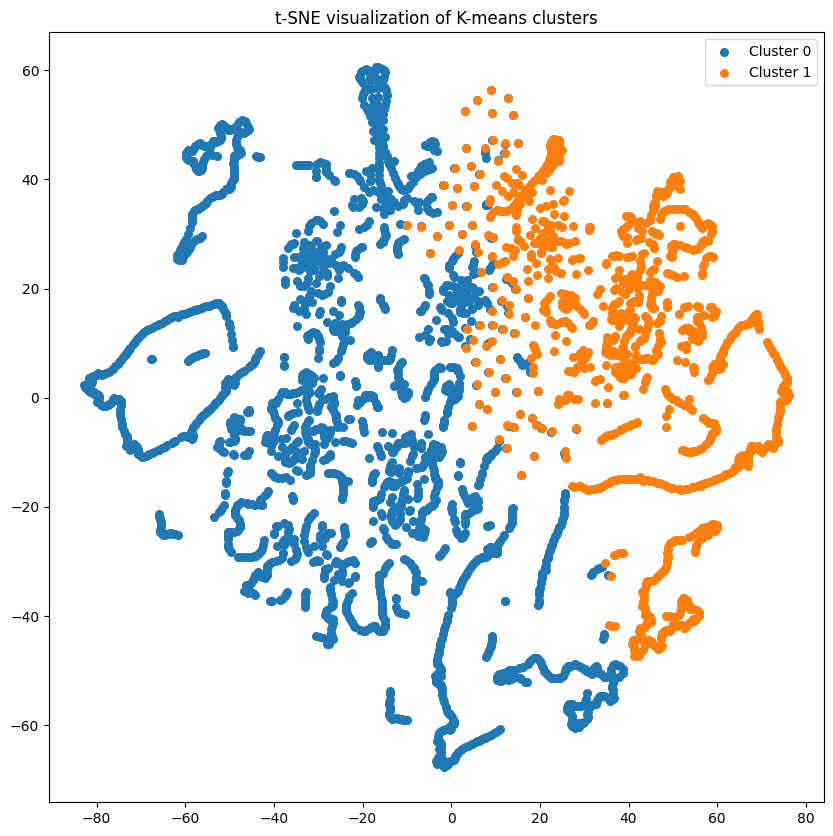

In [27]:
from sklearn.manifold import TSNE
# Use t-SNE to visualize the clusters
tsne = TSNE(n_components=2, random_state=0)
tsne_transformed = tsne.fit_transform(encoded_imgs)

# Plot the clusters
plt.figure(figsize=(10, 10))
colors = plt.cm.tab10(np.linspace(0, 1, 10))
for i in range(2):
    plt.scatter(tsne_transformed[kmeans.labels_ == i, 0],
                tsne_transformed[kmeans.labels_ == i, 1],
                s=30, c=colors[i], label='Cluster %d' % i)
plt.legend()
plt.title('t-SNE visualization of K-means clusters')
plt.show()

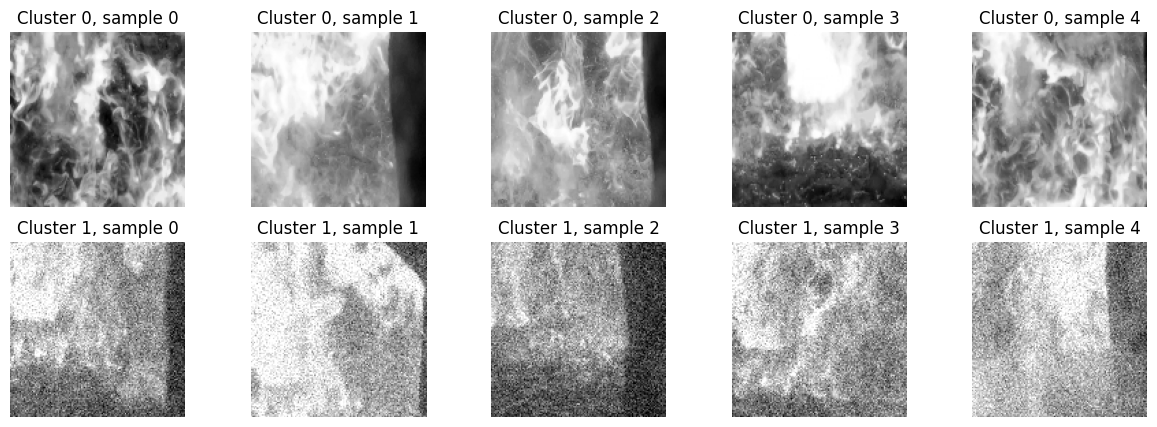

In [28]:
import random
# Display the samples and their corresponding clusters
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
ax = ax.flatten()
n = 0 #Number of images
for i in range(2):
    # Get the indices of the images belonging to cluster i
    indices = np.where(kmeans.labels_ == i)[0]
    
    # Display the 5 first images of each cluster
    for j in range(5):
        random_number = random.randint(0, len(indices)-1)
        ax[n].imshow(X[indices[random_number]].reshape(128,128), cmap='gray')
        ax[n].set_title(f"Cluster {i}, sample {j}")
        ax[n].axis('off')
        n+=1
plt.show()